Bắt đầu xử lý ảnh: ./img/ha-long-bay-in-vietnam.jpg
  Applying: inverse
    Saved: ./output\ha-long-bay-in-vietnam_inverse.jpg


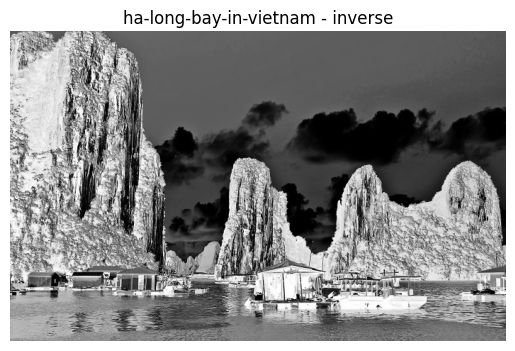

  Applying: gamma_2.2
    Saved: ./output\ha-long-bay-in-vietnam_gamma_2.2.jpg


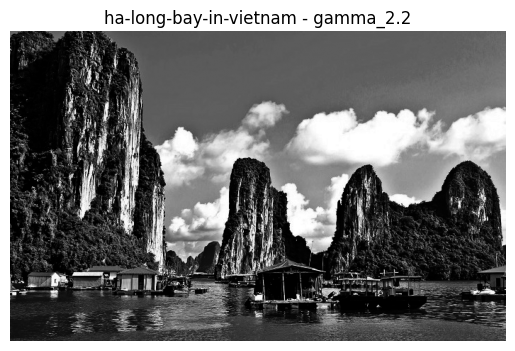

  Applying: log
    Saved: ./output\ha-long-bay-in-vietnam_log.jpg


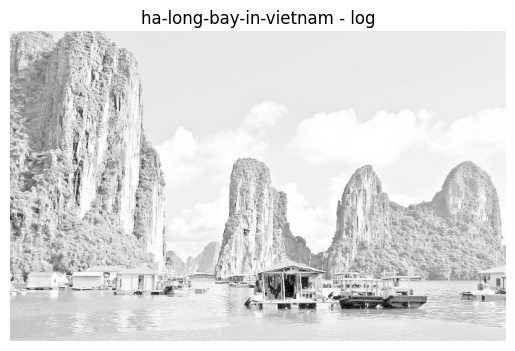

  Applying: histeq
    Saved: ./output\ha-long-bay-in-vietnam_histeq.jpg


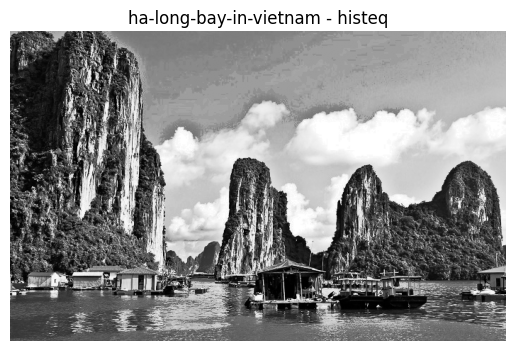

  Applying: contrast
    Saved: ./output\ha-long-bay-in-vietnam_contrast.jpg


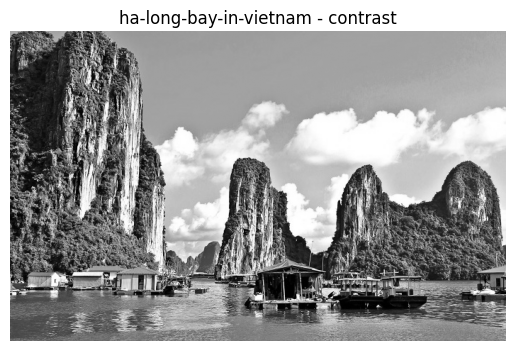


Đã xử lý xong tất cả các phương pháp.
Kết quả được lưu vào thư mục: c:\Users\Shimizu\Workspace\DIT\Lab_2\Exercise\output


In [ ]:
# Bài 1
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from typing import Callable, Tuple, List


def image_inverse(img: np.ndarray) -> np.ndarray:
    """Đảo ngược giá trị pixel của ảnh (Negative transformation)."""
    return 255 - img

def gamma_correction(img: np.ndarray, gamma: float = 2.2) -> np.ndarray:
    """Hiệu chỉnh Gamma cho ảnh."""
    img_float = img.astype(np.float32) / 255.0
    img_gamma = np.power(img_float, gamma)
    return np.clip(img_gamma * 255.0, 0, 255).astype(np.uint8)

def log_transformation(img: np.ndarray) -> np.ndarray:
    """Biến đổi Logarithmic cho ảnh."""
    img_float = img.astype(np.float32)


    max_val = np.max(img_float)
    if max_val == 0:
        return img.copy()

    c = 255.0 / np.log(1 + max_val)
    img_log = c * np.log(1 + img_float)
    return np.clip(img_log, 0, 255).astype(np.uint8)

def histogram_equalization(img: np.ndarray) -> np.ndarray:
    """Cân bằng Histogram cho ảnh."""

    if img.dtype != np.uint8:
        img_uint8 = np.clip(img, 0, 255).astype(np.uint8)
    else:
        img_uint8 = img
    return cv2.equalizeHist(img_uint8)

def contrast_stretching(img: np.ndarray) -> np.ndarray:
    """Giãn tương phản (Contrast Stretching)."""
    a, b = np.min(img), np.max(img)
    if a == b: 
        return img.copy()
    
    img_float = img.astype(np.float32)
    stretched = (img_float - a) * (255.0 / (b - a))
    return np.clip(stretched, 0, 255).astype(np.uint8)


def process_display_and_save(
    img_array_gray: np.ndarray,
    original_file_path: str,
    transform_func: Callable[[np.ndarray], np.ndarray],
    suffix: str,
    output_folder: str = './output_optimized'
) -> None:


    print(f"  Applying: {suffix}")
    try:
        img_transformed = transform_func(img_array_gray.copy())

    
        base_name = os.path.basename(original_file_path)
        name_part, ext_part = os.path.splitext(base_name)
        output_filename = f"{name_part}_{suffix}{ext_part}"
        output_path = os.path.join(output_folder, output_filename)

    
        Image.fromarray(img_transformed).save(output_path)
        print(f"    Saved: {output_path}")

    
        plt.figure()
        plt.imshow(img_transformed, cmap='gray', vmin=0, vmax=255)
        plt.title(f"{name_part} - {suffix}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"    Error processing {suffix} for {original_file_path}: {e}")


def main():
    img_path = './img/ha-long-bay-in-vietnam.jpg' 
    output_dir = './output'

    if not os.path.exists(img_path):
        print(f"Lỗi: Không tìm thấy ảnh tại '{img_path}'")
        return


    os.makedirs(output_dir, exist_ok=True)


    try:
        img_pil = Image.open(img_path).convert('L')
        img_np_gray = np.array(img_pil)
    except Exception as e:
        print(f"Lỗi khi đọc hoặc chuyển đổi ảnh '{img_path}': {e}")
        return

    print(f"Bắt đầu xử lý ảnh: {img_path}")



    transformations: List[Tuple[str, Callable[[np.ndarray], np.ndarray]]] = [
        ('inverse', image_inverse),
        ('gamma_2.2', lambda img: gamma_correction(img, gamma=2.2)),
    
        ('log', log_transformation),
        ('histeq', histogram_equalization),
        ('contrast', contrast_stretching)
    ]


    for suffix, func in transformations:
        process_display_and_save(
            img_np_gray,
            img_path,
            func,
            suffix,
            output_folder=output_dir
        )

    print(f"\nĐã xử lý xong tất cả các phương pháp.")
    print(f"Kết quả được lưu vào thư mục: {os.path.abspath(output_dir)}")

if __name__ == "__main__":
    main()

Đang xử lý: ha-long-bay-in-vietnam.jpg
Đang xử lý: pagoda.jpg
Đang xử lý: quang_ninh.jpg
Đã xử lý xong. Kết quả lưu trong thư mục output



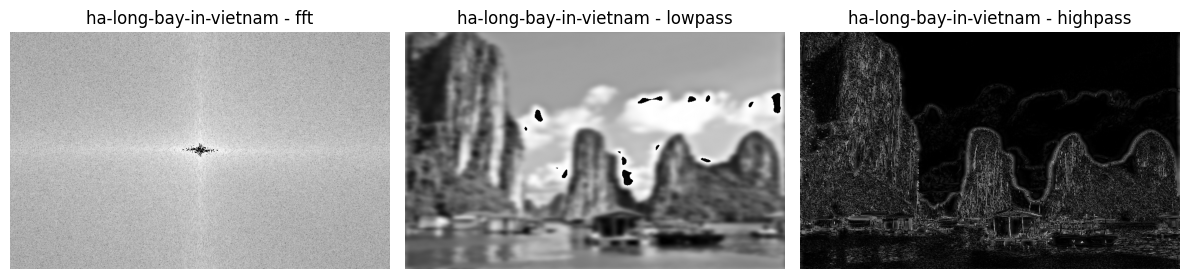

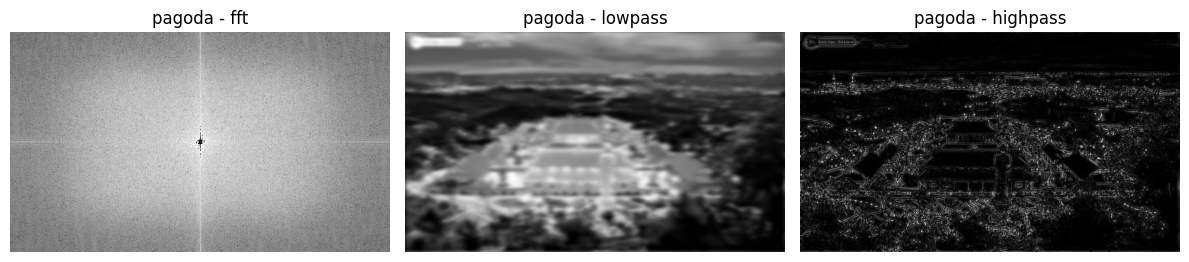

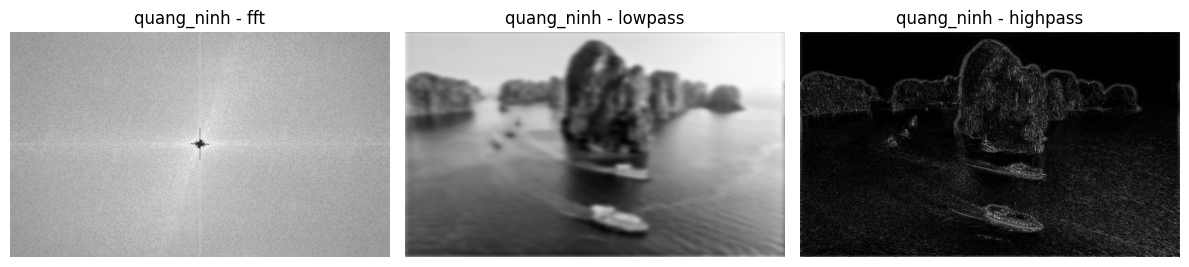

In [7]:
# Bài 2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

def fast_fourier_transform(img):
    fshift = np.fft.fftshift(np.fft.fft2(img))
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    return np.uint8(magnitude_spectrum)

def create_butterworth_filter(shape, d0, n, highpass=False):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    u = np.arange(rows)
    v = np.arange(cols)
    V, U = np.meshgrid(v, u)
    D = np.sqrt((U - crow) ** 2 + (V - ccol) ** 2)
    if highpass:
        H = 1 / (1 + (d0 / (D + 1e-5)) ** (2 * n))  # tránh chia 0
    else:
        H = 1 / (1 + (D / d0) ** (2 * n))
    return H

def apply_filter(img, filter_mask):
    fshift = np.fft.fftshift(np.fft.fft2(img))
    fshift_filtered = fshift * filter_mask
    img_back = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift_filtered)))
    return np.uint8(img_back)

def process_and_collect(img_path, functions):
    img = Image.open(img_path).convert('L')
    img_np = np.array(img)
    file_root = img_path.stem
    out_folder = Path('output')
    out_folder.mkdir(exist_ok=True)

    results = []
    for func, suffix in functions:
        result = func(img_np)
        results.append((suffix, result))
        Image.fromarray(result).save(out_folder / f"{file_root}_{suffix}.jpg")

    return file_root, results

def main():
    folder = Path('./img')
    folder.mkdir(exist_ok=True)
    img_files = list(folder.glob("*.jpg")) + list(folder.glob("*.jpeg")) + list(folder.glob("*.png"))

    if not img_files:
        print("Không tìm thấy ảnh trong thư mục 'img'. Hãy thêm ảnh .jpg/.jpeg/.png rồi chạy lại.")
        return

    def butter_low(img): return apply_filter(img, create_butterworth_filter(img.shape, d0=30, n=2))
    def butter_high(img): return apply_filter(img, create_butterworth_filter(img.shape, d0=30, n=2, highpass=True))

    functions = [
        (fast_fourier_transform, 'fft'),
        (butter_low, 'lowpass'),
        (butter_high, 'highpass')
    ]

    all_results = []
    for img_path in img_files:
        print("Đang xử lý:", img_path.name)
        name, results = process_and_collect(img_path, functions)
        all_results.append((name, results))

    print("Đã xử lý xong. Kết quả lưu trong thư mục output\n")

    for name, results in all_results:
        plt.figure(figsize=(12, 4))
        for i, (suffix, img_result) in enumerate(results):
            plt.subplot(1, len(results), i + 1)
            plt.imshow(img_result, cmap='gray')
            plt.title(f"{name} - {suffix}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()


Đang xử lý: ha-long-bay-in-vietnam.jpg


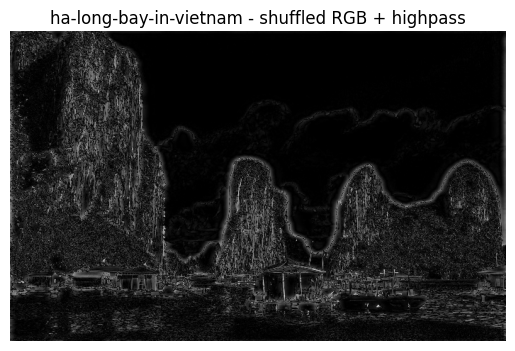

Đang xử lý: pagoda.jpg


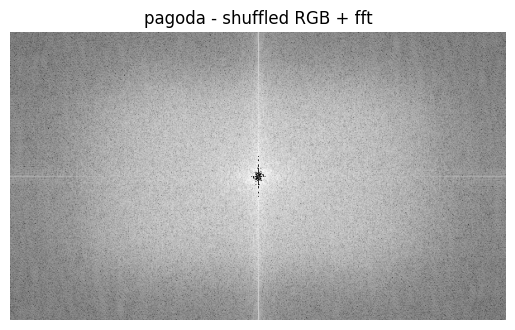

Đang xử lý: quang_ninh.jpg


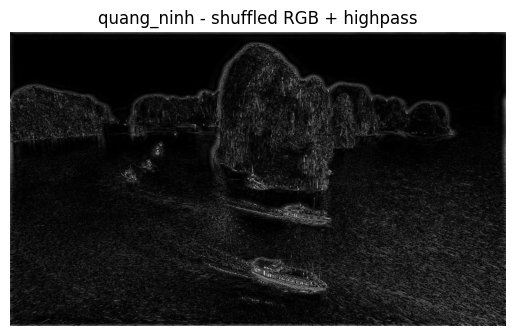

Đã xử lý xong tất cả ảnh. Kết quả lưu trong thư mục output


In [8]:
# Bài 3
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# === Bộ filter FFT dùng lại ===
def create_butterworth_filter(shape, d0, n, highpass=False):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    u = np.arange(rows)
    v = np.arange(cols)
    V, U = np.meshgrid(v, u)
    D = np.sqrt((U - crow)**2 + (V - ccol)**2)
    if highpass:
        H = 1 / (1 + (d0 / (D + 1e-5))**(2 * n))
    else:
        H = 1 / (1 + (D / d0)**(2 * n))
    return H

def apply_filter(img_gray, H):
    fshift = np.fft.fftshift(np.fft.fft2(img_gray))
    fshift_filtered = fshift * H
    img_back = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift_filtered)))
    return np.uint8(img_back)

def fast_fourier_transform(img_gray):
    fshift = np.fft.fftshift(np.fft.fft2(img_gray))
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    return np.uint8(magnitude_spectrum)

# === Biến đổi shuffle RGB ===
def shuffle_rgb(img_rgb):
    channels = list(img_rgb.split())
    random.shuffle(channels)
    return Image.merge('RGB', channels)

# === Hàm xử lý một ảnh ===
def process_image(img_path, transforms, out_folder):
    img = Image.open(img_path).convert('RGB')
    file_root = img_path.stem

    img_shuffled = shuffle_rgb(img)
    img_gray = np.array(img_shuffled.convert('L'))

    func, suffix = random.choice(transforms)
    result_img = func(img_gray)

    out_path = out_folder / f"{file_root}_shuffled_{suffix}.jpg"
    Image.fromarray(result_img).save(out_path)

    plt.imshow(result_img, cmap='gray')
    plt.title(f"{file_root} - shuffled RGB + {suffix}")
    plt.axis('off')
    plt.show()

def main():
    folder = Path('img')
    folder.mkdir(exist_ok=True)

    img_files = list(folder.glob("*.jpg")) + list(folder.glob("*.jpeg")) + list(folder.glob("*.png"))
    if not img_files:
        print("Không tìm thấy ảnh trong thư mục 'img'. Hãy thêm ảnh .jpg/.jpeg/.png.")
        return

    out_folder = Path('output')
    out_folder.mkdir(exist_ok=True)

    # Khai báo các transform
    transforms = [
        (fast_fourier_transform, 'fft'),
        (lambda img: apply_filter(img, create_butterworth_filter(img.shape, d0=30, n=2)), 'lowpass'),
        (lambda img: apply_filter(img, create_butterworth_filter(img.shape, d0=30, n=2, highpass=True)), 'highpass'),
    ]

    for img_path in img_files:
        print("Đang xử lý:", img_path.name)
        process_image(img_path, transforms, out_folder)

    print("Đã xử lý xong tất cả ảnh. Kết quả lưu trong thư mục output")

if __name__ == "__main__":
    main()


Đang xử lý: ha-long-bay-in-vietnam.jpg


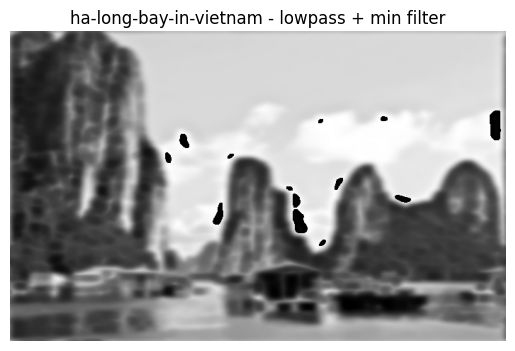

Đang xử lý: pagoda.jpg


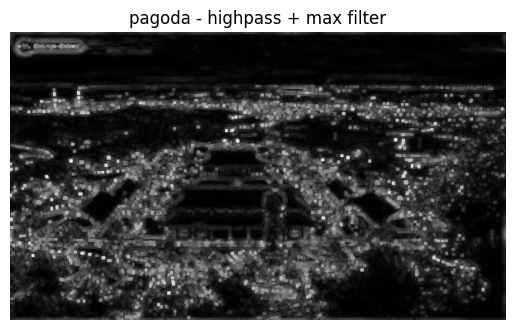

Đang xử lý: quang_ninh.jpg


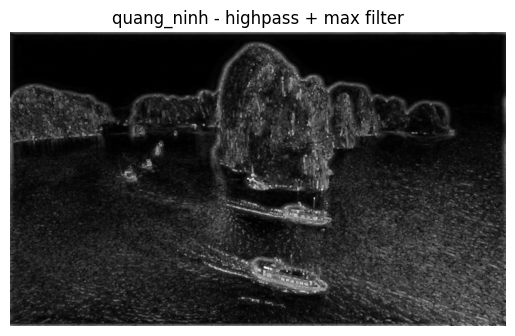

Hoàn tất xử lý tất cả ảnh. Kết quả lưu trong thư mục output


In [9]:
# Bài 4
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from pathlib import Path

# === Bộ lọc Butterworth (dùng lại) ===
def create_butterworth_filter(shape, d0, n=2, highpass=False):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    u = np.arange(rows)
    v = np.arange(cols)
    V, U = np.meshgrid(v, u)
    D = np.sqrt((U - crow)**2 + (V - ccol)**2)
    if highpass:
        H = 1 / (1 + (d0 / (D + 1e-5))**(2 * n))  # tránh chia 0
    else:
        H = 1 / (1 + (D / d0)**(2 * n))
    return H

def apply_filter(img_gray, H):
    fshift = np.fft.fftshift(np.fft.fft2(img_gray))
    f_filtered = fshift * H
    img_back = np.abs(np.fft.ifft2(np.fft.ifftshift(f_filtered)))
    return np.uint8(img_back)

# === RGB shuffle ===
def shuffle_rgb(img_rgb):
    channels = list(img_rgb.split())
    random.shuffle(channels)
    return Image.merge('RGB', channels)

# === Min/Max filter (gộp chung) ===
def apply_pil_filter(img_array, mode='min'):
    img = Image.fromarray(img_array)
    if mode == 'min':
        return np.array(img.filter(ImageFilter.MinFilter(size=3)))
    elif mode == 'max':
        return np.array(img.filter(ImageFilter.MaxFilter(size=3)))
    else:
        raise ValueError("Chế độ lọc không hợp lệ. Chọn 'min' hoặc 'max'.")

# === Xử lý 1 ảnh ===
def process_image(img_path, out_folder, transforms):
    img_rgb = Image.open(img_path).convert('RGB')
    file_root = img_path.stem

    img_shuffled = shuffle_rgb(img_rgb)
    img_gray = np.array(img_shuffled.convert('L'))

    freq_func, suffix, filter_mode = random.choice(transforms)
    freq_result = freq_func(img_gray)
    filtered_result = apply_pil_filter(freq_result, mode=filter_mode)

    out_path = out_folder / f"{file_root}_shuffled_{suffix}_filtered.jpg"
    Image.fromarray(filtered_result).save(out_path)

    plt.imshow(filtered_result, cmap='gray')
    plt.title(f"{file_root} - {suffix} + {filter_mode} filter")
    plt.axis('off')
    plt.show()

def main():
    folder = Path('img')
    folder.mkdir(exist_ok=True)
    img_files = list(folder.glob("*.jpg")) + list(folder.glob("*.jpeg")) + list(folder.glob("*.png"))

    if not img_files:
        print("Không tìm thấy ảnh hợp lệ trong thư mục 'img'.")
        return

    out_folder = Path('output')
    out_folder.mkdir(exist_ok=True)

    # Tập hợp các biến đổi tần số + lọc
    transforms = [
        (lambda img: apply_filter(img, create_butterworth_filter(img.shape, d0=30, n=2)), 'lowpass', 'min'),
        (lambda img: apply_filter(img, create_butterworth_filter(img.shape, d0=30, n=2, highpass=True)), 'highpass', 'max'),
    ]

    for img_path in img_files:
        print("Đang xử lý:", img_path.name)
        process_image(img_path, out_folder, transforms)

    print("Hoàn tất xử lý tất cả ảnh. Kết quả lưu trong thư mục output")

if __name__ == "__main__":
    main()
